# **Imports**

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# **1. Perceptron Algo**

In [3]:
# Generate linearly separable data
np.random.seed(0)
num_points = 1300
class_1_x = np.random.normal(loc=0, scale=1, size=num_points // 2)
class_1_y = np.random.normal(loc=0, scale=1, size=num_points // 2)
class_2_x = np.random.normal(loc=3, scale=1, size=num_points // 2)
class_2_y = np.random.normal(loc=3, scale=1, size=num_points // 2)

# Combine data points and labels
X = np.vstack((np.column_stack((class_1_x, class_1_y)), np.column_stack((class_2_x, class_2_y))))
y = np.concatenate((np.zeros(num_points // 2), np.ones(num_points // 2)))
df = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'y': y})

In [4]:
def plot(df, title):
  plt.figure(figsize=(8, 6))
  plt.scatter(df.loc[df['y'] == 0, 'x1'], df.loc[df['y'] == 0, 'x2'], label="Class 0", color='blue')
  plt.scatter(df.loc[df['y'] == 1, 'x1'], df.loc[df['y'] == 1, 'x2'], label="Class 1", color='red')
  plt.xlabel("Feature X")
  plt.ylabel("Feature Y")
  plt.title(title)
  plt.legend()
  plt.show()

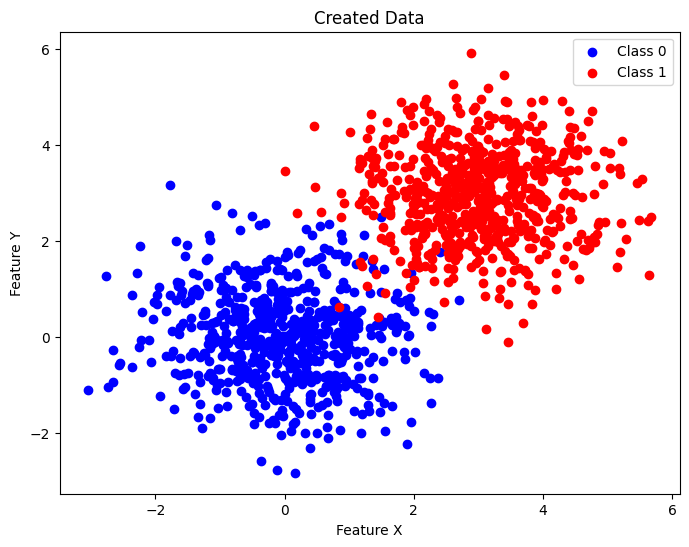

In [5]:
plot(df,"Created Data")

In [6]:
print(df.head())
X = torch.tensor(df.drop('y',axis=1).values, dtype=torch.float32)
y = torch.tensor(df['y'].values, dtype=torch.float32).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

         x1        x2    y
0  1.764052  0.286904  0.0
1  0.400157 -2.320594  0.0
2  0.978738  0.317161  0.0
3  2.240893  0.520041  0.0
4  1.867558  0.225609  0.0


In [7]:
class Perceptron(nn.Module):
  def __init__(self,input):
    super().__init__()  # Call the parent class's __init__ method
    self.layer = nn.Linear(input,1)
  def forward(self,x):
    return torch.sigmoid(self.layer(x))

In [8]:
model = Perceptron(2).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.BCELoss()
epoch=1000

In [9]:
def traintest(model, X_train, y_train, X_test, y_test, optimizer, criterion, epochs, device):
    model.to(device)
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for i in range(epochs):
        model.train()
        y_pred = model(X_train.to(device))
        loss = criterion(y_pred, y_train.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_acc = (y_pred.round() == y_train.to(device)).float().mean().item()
        train_losses.append(loss.item())
        train_accs.append(train_acc)

        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test.to(device))
            test_loss = criterion(y_test_pred, y_test.to(device))
            test_acc = (y_test_pred.round() == y_test.to(device)).float().mean().item()

            test_losses.append(test_loss.item())
            test_accs.append(test_acc)

        if i % 100 == 0:
            print(f"Epoch {i}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return model, train_losses, test_losses, train_accs, test_accs

In [12]:
trainded_model, train_losses, test_losses, train_accs, test_accs = traintest(model, X_train, y_train, X_test, y_test, optimizer, criterion, epoch, device)

Epoch 0/1000, Train Loss: 0.8554, Test Loss: 0.7109, Train Acc: 0.2683, Test Acc: 0.5154
Epoch 100/1000, Train Loss: 0.1975, Test Loss: 0.2025, Train Acc: 0.9442, Test Acc: 0.9423
Epoch 200/1000, Train Loss: 0.1363, Test Loss: 0.1398, Train Acc: 0.9673, Test Acc: 0.9808
Epoch 300/1000, Train Loss: 0.1099, Test Loss: 0.1135, Train Acc: 0.9702, Test Acc: 0.9769
Epoch 400/1000, Train Loss: 0.0951, Test Loss: 0.0990, Train Acc: 0.9750, Test Acc: 0.9769
Epoch 500/1000, Train Loss: 0.0854, Test Loss: 0.0898, Train Acc: 0.9788, Test Acc: 0.9808
Epoch 600/1000, Train Loss: 0.0786, Test Loss: 0.0834, Train Acc: 0.9808, Test Acc: 0.9846
Epoch 700/1000, Train Loss: 0.0735, Test Loss: 0.0787, Train Acc: 0.9817, Test Acc: 0.9846
Epoch 800/1000, Train Loss: 0.0695, Test Loss: 0.0750, Train Acc: 0.9827, Test Acc: 0.9846
Epoch 900/1000, Train Loss: 0.0663, Test Loss: 0.0722, Train Acc: 0.9808, Test Acc: 0.9846


In [13]:
def plot_loss_acc(train_losses, test_losses, train_accs, test_accs):
    epochs = range(len(train_losses))

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, test_losses, label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Acc', color='blue')
    plt.plot(epochs, test_accs, label='Test Acc', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.legend()

    plt.show()


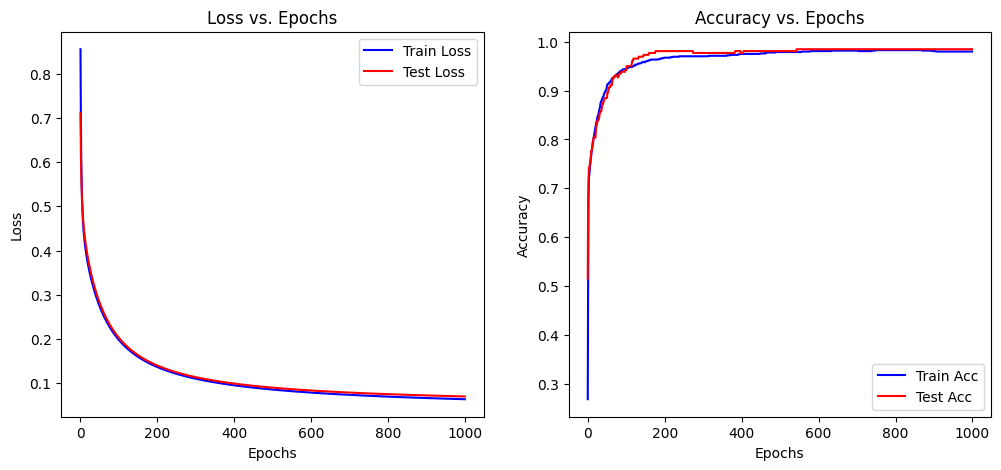

In [14]:
plot_loss_acc(train_losses, test_losses, train_accs, test_accs)

In [15]:
def plot_decision_boundary(model, X, y):
    # Create a meshgrid of points to evaluate the model on
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict the class for each point in the meshgrid
    with torch.no_grad():
        Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device))
        Z = (Z > 0.5).float().cpu().numpy()
    Z = Z.reshape(xx.shape)
    # Plot the decision boundary and the data points with modified colors
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')  # Changed colormap
    plt.scatter(X[:, 0], X[:, 1], c=['blue' if val == 0 else 'red' for val in y], alpha=0.8)  # Changed data point colors
    plt.xlabel("Feature X")
    plt.ylabel("Feature Y")
    plt.title("Decision Boundary")
    plt.show()

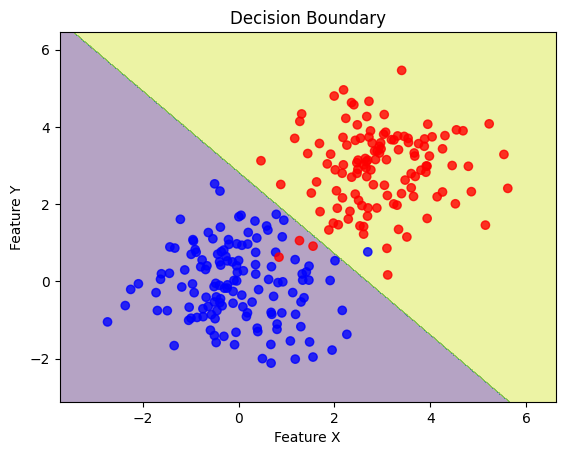

In [16]:
plot_decision_boundary(model, X_test, y_test)

In [17]:
num_noisy_points = int(0.1 * len(y_train))
noisy_indices = np.random.choice(len(y_train), num_noisy_points, replace=False)
y_train[noisy_indices] = 1 - y_train[noisy_indices]
df_noisy=df.copy()
df_noisy.loc[noisy_indices, 'y'] = 1 - df_noisy.loc[noisy_indices, 'y']

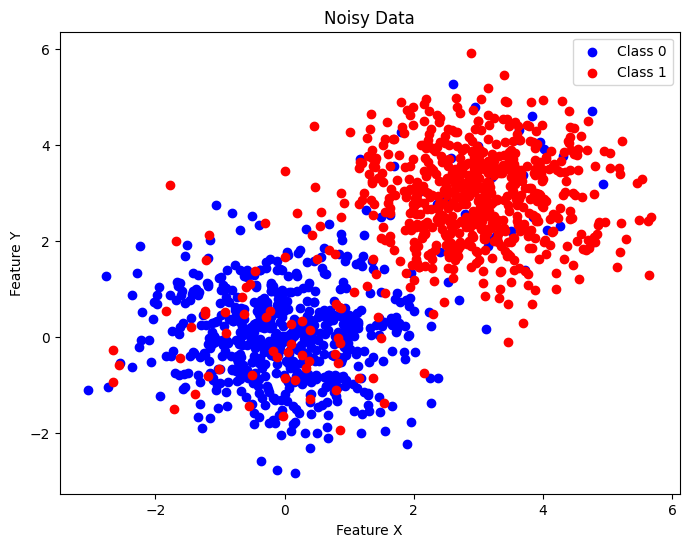

In [18]:
plot(df_noisy,"Noisy Data")

In [19]:
df_noisy.head()

,x1,x2,y
0,1.764052,0.286904,0.0
1,0.400157,-2.320594,0.0
2,0.978738,0.317161,0.0
3,2.240893,0.520041,0.0
4,1.867558,0.225609,0.0


In [ ]:
X_noisy=df_noisy.drop('y',axis=1)
y_noisy=df_noisy['y']
X_noisy = torch.tensor(X_train, dtype=torch.float32)
y_noisy = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, y_noisy, test_size=0.2, random_state=42)

In [21]:
model_noisy = Perceptron(2).to(device)
optimizer_noisy = optim.SGD(model_noisy.parameters(), lr=0.1)
criterion = nn.BCELoss()
epoch=1000

In [22]:
trainded_model2, train_losses2, test_losses2, train_accs2, test_accs2= traintest(model_noisy,X_train_noisy,y_train_noisy,X_test_noisy,y_test_noisy,optimizer_noisy,criterion,epoch,device)

Epoch 0/1000, Train Loss: 0.6316, Test Loss: 0.5855, Train Acc: 0.8341, Test Acc: 0.8510
Epoch 100/1000, Train Loss: 0.3884, Test Loss: 0.4499, Train Acc: 0.8726, Test Acc: 0.8558
Epoch 200/1000, Train Loss: 0.3697, Test Loss: 0.4412, Train Acc: 0.8846, Test Acc: 0.8606
Epoch 300/1000, Train Loss: 0.3645, Test Loss: 0.4411, Train Acc: 0.8870, Test Acc: 0.8606
Epoch 400/1000, Train Loss: 0.3627, Test Loss: 0.4424, Train Acc: 0.8894, Test Acc: 0.8654
Epoch 500/1000, Train Loss: 0.3621, Test Loss: 0.4435, Train Acc: 0.8930, Test Acc: 0.8702
Epoch 600/1000, Train Loss: 0.3618, Test Loss: 0.4444, Train Acc: 0.8930, Test Acc: 0.8702
Epoch 700/1000, Train Loss: 0.3617, Test Loss: 0.4450, Train Acc: 0.8942, Test Acc: 0.8702
Epoch 800/1000, Train Loss: 0.3616, Test Loss: 0.4454, Train Acc: 0.8942, Test Acc: 0.8702
Epoch 900/1000, Train Loss: 0.3616, Test Loss: 0.4457, Train Acc: 0.8942, Test Acc: 0.8702


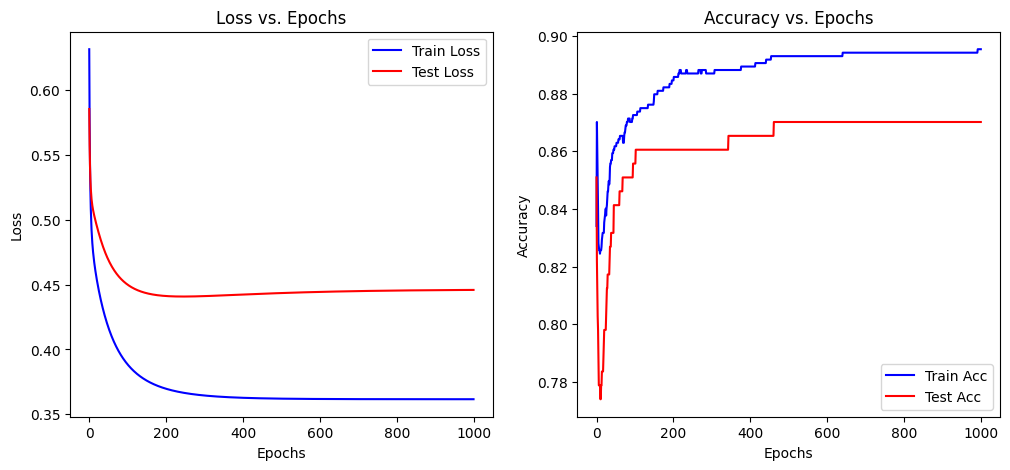

In [23]:
plot_loss_acc(train_losses2, test_losses2, train_accs2, test_accs2)

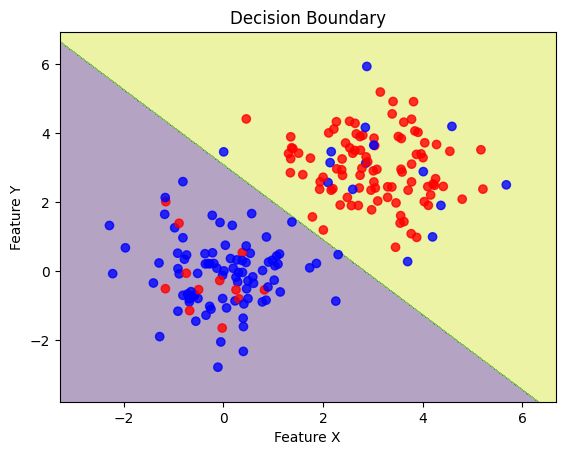

In [24]:
plot_decision_boundary(model_noisy, X_test_noisy, y_test_noisy)

# **2. Gradient Descent**

In [25]:
class Perceptron(nn.Module):
  def __init__(self,input):
    super().__init__()  # Call the parent class's __init__ method
    self.layer = nn.Linear(input,1)
  def forward(self,x):
    return torch.sigmoid(self.layer(x))

In [26]:
model3 = Perceptron(2).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.BCELoss()
epoch=1000

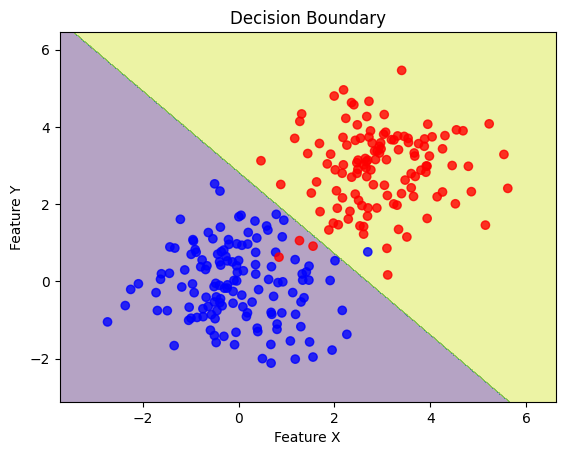

In [27]:
plot_decision_boundary(model, X_test, y_test)

In [28]:
model_noisy2 = Perceptron(2).to(device)
optimizer_noisy2 = optim.SGD(model_noisy.parameters(), lr=0.1)
criterion = nn.HingeEmbeddingLoss()
epoch=1000

In [31]:
trainded_model3, train_losses3, test_losses3, train_accs3, test_accs3 = traintest(model_noisy2,X_train_noisy,y_train_noisy,X_test_noisy,y_test_noisy,optimizer_noisy2,criterion,epoch,device)

Epoch 0/1000, Train Loss: 0.8625, Test Loss: 0.8576, Train Acc: 0.8161, Test Acc: 0.7885
Epoch 100/1000, Train Loss: 0.8625, Test Loss: 0.8576, Train Acc: 0.8161, Test Acc: 0.7885
Epoch 200/1000, Train Loss: 0.8625, Test Loss: 0.8576, Train Acc: 0.8161, Test Acc: 0.7885
Epoch 300/1000, Train Loss: 0.8625, Test Loss: 0.8576, Train Acc: 0.8161, Test Acc: 0.7885
Epoch 400/1000, Train Loss: 0.8625, Test Loss: 0.8576, Train Acc: 0.8161, Test Acc: 0.7885
Epoch 500/1000, Train Loss: 0.8625, Test Loss: 0.8576, Train Acc: 0.8161, Test Acc: 0.7885
Epoch 600/1000, Train Loss: 0.8625, Test Loss: 0.8576, Train Acc: 0.8161, Test Acc: 0.7885
Epoch 700/1000, Train Loss: 0.8625, Test Loss: 0.8576, Train Acc: 0.8161, Test Acc: 0.7885
Epoch 800/1000, Train Loss: 0.8625, Test Loss: 0.8576, Train Acc: 0.8161, Test Acc: 0.7885
Epoch 900/1000, Train Loss: 0.8625, Test Loss: 0.8576, Train Acc: 0.8161, Test Acc: 0.7885


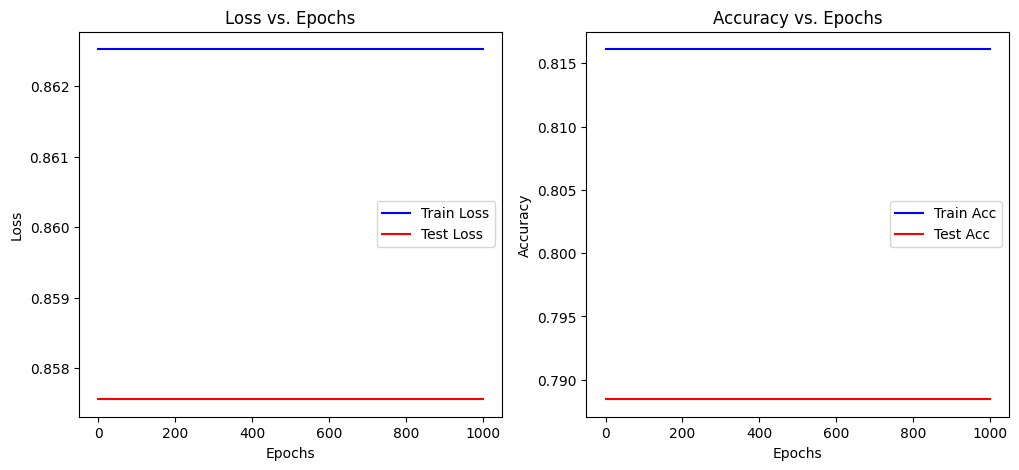

In [32]:
plot_loss_acc(train_losses3, test_losses3, train_accs3, test_accs3)

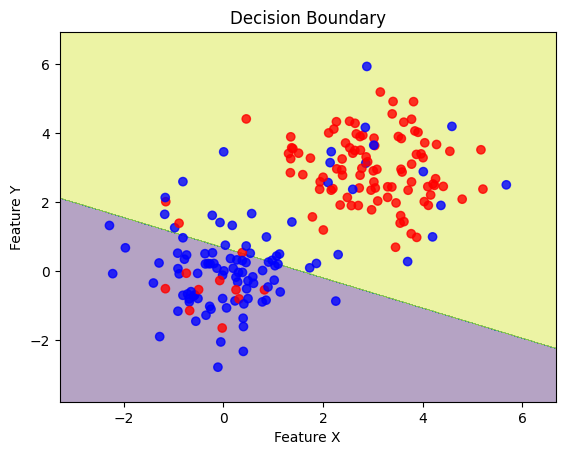

In [33]:
plot_decision_boundary(model_noisy2, X_test_noisy, y_test_noisy)

# **3. Multilayer Perceptron**